
# 🎬 Proyecto extra — TMDb 5000 (movies & credits): calidad de datos y joins

**Unidad:** UT2 — Calidad y Ética de los Datos  
**Archivos Kaggle:** `tmdb_5000_movies.csv` y `tmdb_5000_credits.csv`  
**Objetivo:** evaluar calidad (nulos, duplicados, rangos) e integridad referencial entre `movies` y `credits`.


In [2]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

MOVIES_CSV = Path("tmdb_5000_movies.csv")
CREDITS_CSV = Path("tmdb_5000_credits.csv")

assert MOVIES_CSV.exists(), "No se encontró tmdb_5000_movies.csv"
assert CREDITS_CSV.exists(), "No se encontró tmdb_5000_credits.csv"


In [ ]:

movies = pd.read_csv(MOVIES_CSV, low_memory=False)
credits = pd.read_csv(CREDITS_CSV)
movies.shape, credits.shape, movies.columns.tolist()[:10], credits.columns.tolist()

((4803, 20),
 (4803, 4),
 ['budget',
  'genres',
  'homepage',
  'id',
  'keywords',
  'original_language',
  'original_title',
  'overview',
  'popularity',
  'production_companies'],
 ['movie_id', 'title', 'cast', 'crew'])

In [ ]:

# Copias de trabajo
dfm = movies.copy()
dfc = credits.copy()

# Cast básicos
dfm['release_date'] = pd.to_datetime(dfm['release_date'], errors='coerce')

# Presupuesto/ingresos/runtime a numérico (algunos vienen como strings)
for col in ['budget','revenue','runtime']:
    dfm[col] = pd.to_numeric(dfm[col], errors='coerce')

# IDs
dfm['id'] = pd.to_numeric(dfm['id'], errors='coerce')
dfc['movie_id'] = pd.to_numeric(dfc['movie_id'], errors='coerce')

dfm[['id','title','release_date','budget','revenue','runtime']].head()


,id,title,release_date,budget,revenue,runtime
0,19995,Avatar,2009-12-10,237000000,2787965087,162.0
1,285,Pirates of the Caribbean: At World's End,2007-05-19,300000000,961000000,169.0
2,206647,Spectre,2015-10-26,245000000,880674609,148.0
3,49026,The Dark Knight Rises,2012-07-16,250000000,1084939099,165.0
4,49529,John Carter,2012-03-07,260000000,284139100,132.0


### ✅ Checks de calidad: nulos, duplicados, rangos

In [ ]:

# Nulos críticos
nulls = {
    'title_nulls': int(dfm['title'].isna().sum()),
    'date_nulls': int(dfm['release_date'].isna().sum()),
    'id_nulls': int(dfm['id'].isna().sum()),
}
nulls


{'title_nulls': 0, 'date_nulls': 1, 'id_nulls': 0}

In [ ]:

# Duplicados por (title, release_date)
dups = dfm.groupby(['title','release_date'], dropna=False).size().reset_index(name='n')
dups = dups[dups['n']>1].sort_values('n', ascending=False)
dups.head(10)


,title,release_date,n


In [ ]:

# Rangos plausibles
range_checks = {
    'budget_negative_or_nulls': int(((dfm['budget'] < 0) | dfm['budget'].isna()).sum()),
    'revenue_negative_or_nulls': int(((dfm['revenue'] < 0) | dfm['revenue'].isna()).sum()),
    'runtime_out_of_range': int(((dfm['runtime'] <= 0) | (dfm['runtime'] > 500) | dfm['runtime'].isna()).sum())
}
range_checks


{'budget_negative_or_nulls': 0,
 'revenue_negative_or_nulls': 0,
 'runtime_out_of_range': 37}

### 🔗 Integridad referencial (credits ↔︎ movies)

In [ ]:

# movie_ids en credits que no aparecen en movies.id
movies_ids = set(dfm['id'].dropna().astype(int))
credits_ids = set(dfc['movie_id'].dropna().astype(int))
orphans_in_credits = sorted(list(credits_ids - movies_ids))[:20]  # muestra
len_orphans = len(credits_ids - movies_ids)
len_orphans, orphans_in_credits


(0, [])

## 📊 Visualizaciones

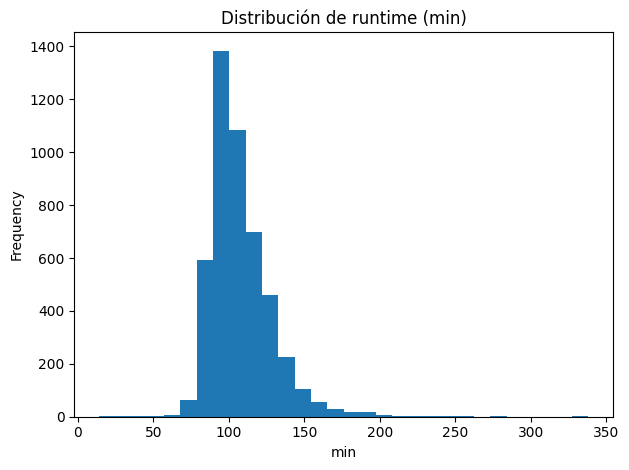

In [ ]:

# Histograma de runtime (válidos)
valid_runtime = dfm['runtime'].dropna()
valid_runtime = valid_runtime[(valid_runtime>0) & (valid_runtime<=500)]
valid_runtime.plot(kind='hist', bins=30, title='Distribución de runtime (min)')
plt.xlabel('min'); plt.tight_layout(); plt.show()


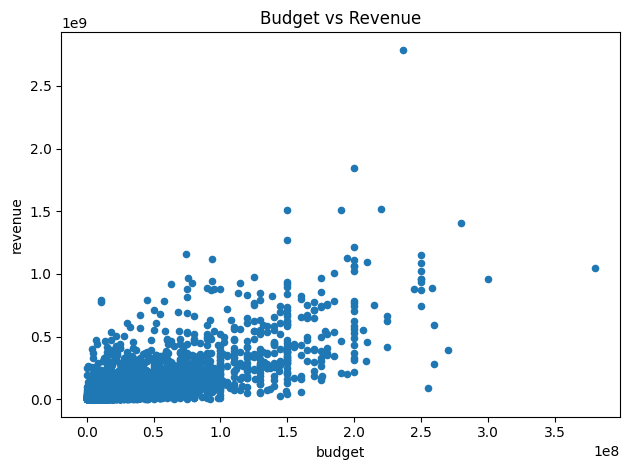

In [ ]:

# Scatter budget vs revenue (solo valores positivos)
subset = dfm[(dfm['budget']>0) & (dfm['revenue']>0)]
subset.plot(kind='scatter', x='budget', y='revenue', title='Budget vs Revenue')
plt.tight_layout(); plt.show()
